In [3]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import random
import os
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_Test.zip" -d "/content"

In [ ]:
## Descargamos y descomprimimos los pesos "AdvProp" más recientes
## de EfficientNetB2
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/advprop/efficientnet-b2.tar.gz
!tar -xf efficientnet-b2.tar.gz -C /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle

In [ ]:
## Convertimos los pesos a formato h5
!python /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnet_weight_update_util.py --model b2 --notop --ckpt \
        /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnet-b2/model.ckpt --o /content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnetb2_advprop_notop.h5

In [5]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [6]:
## Leemos las imágenes de train, validacion y test

training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)


Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


2022/03/15 18:50:52 INFO mlflow.tracking.fluent: Experiment with name 'EfficientNetB2 sin DataAugmentation (AdvProp)' does not exist. Creating a new experiment.


Epoch 1/25
257/257 [==============================] - 86s 253ms/step - loss: 2.4510 - accuracy: 0.5428 - val_loss: 1.2854 - val_accuracy: 0.6371
Epoch 2/25
257/257 [==============================] - 61s 237ms/step - loss: 1.4551 - accuracy: 0.6542 - val_loss: 1.0818 - val_accuracy: 0.6980
Epoch 3/25
257/257 [==============================] - 61s 238ms/step - loss: 1.1386 - accuracy: 0.6848 - val_loss: 1.0154 - val_accuracy: 0.7009
Epoch 4/25
257/257 [==============================] - 62s 238ms/step - loss: 0.9881 - accuracy: 0.7019 - val_loss: 0.9195 - val_accuracy: 0.7224
Epoch 5/25
257/257 [==============================] - 61s 237ms/step - loss: 0.9260 - accuracy: 0.7134 - val_loss: 0.9401 - val_accuracy: 0.7097
Epoch 6/25
257/257 [==============================] - 61s 237ms/step - loss: 0.8787 - accuracy: 0.7168 - val_loss: 0.9256 - val_accuracy: 0.7194
Epoch 7/25
257/257 [==============================] - 62s 239ms/step - loss: 0.8826 - accuracy: 0.7251 - val_loss: 1.0314 - val_ac

2022/03/15 18:59:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


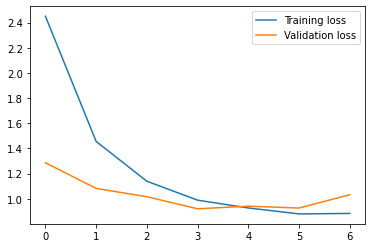

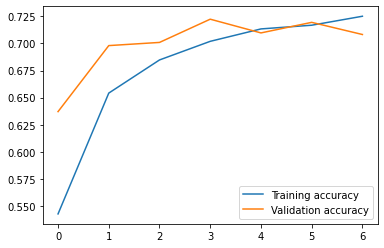

In [7]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

## Vamos a entrenar usando la red EfficietNetB2
base_model = tf.keras.applications.EfficientNetB2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/efficientnetb2_advprop_notop.h5',
                                               pooling='avg')

base_model.trainable = False

normalization = Rescaling(1./255)
prediction_layer = Dense(29, activation="softmax")

model = Sequential([
  #normalization,
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])

opt = Adam(learning_rate=1e-2)
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("EfficientNetB2 sin DataAugmentation (AdvProp)")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=25,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

Epoch 1/10
257/257 [==============================] - 250s 901ms/step - loss: 1.4094 - accuracy: 0.6308 - val_loss: 0.7866 - val_accuracy: 0.7589
Epoch 2/10
257/257 [==============================] - 227s 884ms/step - loss: 0.6246 - accuracy: 0.8008 - val_loss: 0.5506 - val_accuracy: 0.8208
Epoch 3/10
257/257 [==============================] - 227s 883ms/step - loss: 0.4274 - accuracy: 0.8547 - val_loss: 0.4256 - val_accuracy: 0.8602
Epoch 4/10
257/257 [==============================] - 227s 882ms/step - loss: 0.3318 - accuracy: 0.8873 - val_loss: 0.4614 - val_accuracy: 0.8495
Epoch 5/10
257/257 [==============================] - 227s 883ms/step - loss: 0.2621 - accuracy: 0.9083 - val_loss: 0.3620 - val_accuracy: 0.8773
Epoch 6/10
257/257 [==============================] - 227s 883ms/step - loss: 0.2190 - accuracy: 0.9243 - val_loss: 0.4297 - val_accuracy: 0.8665
Epoch 7/10
257/257 [==============================] - 227s 883ms/step - loss: 0.1790 - accuracy: 0.9368 - val_loss: 0.4241 -

2022/03/15 19:33:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


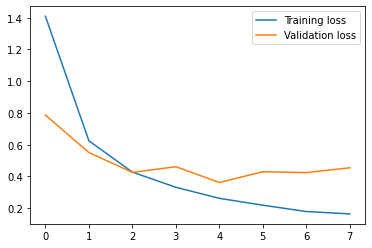

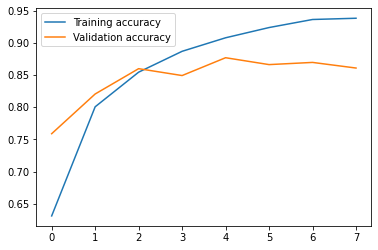

In [8]:
## FINE TUNING: Volvemos a entrenar descongelando algunas capas (menos las BatchNormalization)

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    opt = Adam(learning_rate=1e-4)
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])


unfreeze_model(model)

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=10,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

In [9]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 10 10 ...  9  9 15]


In [10]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('EfficientNetB2_AdvProp_no_DataAugmentation.csv', index=False)
files.download('EfficientNetB2_AdvProp_no_DataAugmentation.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>